In [1]:
import sys
import os
import numpy as np
import napari
%matplotlib inline
from matplotlib import pyplot as plt  # graphic library, for plots
#import seaborn as sns
import numba as nb

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure, show
from bokeh.sampledata.stocks import AAPL

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
import filedialogs

In [4]:
from metavision_core.event_io.raw_reader import RawReader
from metavision_core.event_io.py_reader import EventDatReader
from metavision_core.event_io import EventsIterator

In [5]:
path = filedialogs.gui_fname('example_data/')
path = path.decode('ascii')

In [6]:
record_raw = RawReader(path)
print(record_raw)

RawReader(E:/code/github-ffvoigt/accordion/playground/example_data/fish_bouts_recording_2023-06-27_10-42-58.raw)
current time : 0us done : False
current event index : 0
_begin_buffer 0,_end_buffer_ 0,  buffer_size 10000000


In [7]:
events = record_raw.load_n_events(1000000)
print(events)

[(834, 596, 1,     8214) (925,   4, 0,     9194) (767, 127, 0,     9410)
 ... (829, 542, 0, 15191063) (771, 162, 0, 15191064)
 (810, 484, 0, 15191067)]


In [8]:
events['t'].max()

15191067

In [20]:
minievents = events[1:10]

In [24]:
for event in minievents:
    print(event[0])

925
767
1188
312
292
92
1104
229
1033


In [25]:
import numba as nb

In [9]:
def calculate_bins(events, dt=1000):
    # calculate events for timestep dt in us
    min_timepoint = events['t'].min()
    max_timepoint = events['t'].max()
    interval_us = max_timepoint-min_timepoint
    timepoints = int(interval_us / (dt))
    bins = np.linspace(min_timepoint, max_timepoint, timepoints)
    return bins

def calculate_bin_number(events, dt=1000):
    # calculate events for timestep dt in us
    min_timepoint = events['t'].min()
    max_timepoint = events['t'].max()
    timepoints = int(np.floor((max_timepoint-min_timepoint) / (dt)))
    return timepoints

In [27]:
@nb.njit
def cond_nb(x, k=1):
    return x < k

In [32]:
@nb.njit
def filter_nb(arr, cond_nb):
    result = np.empty_like(arr)
    j = 0
    for i in range(arr.size):
        if cond_nb(arr[i]):
            result[j] = arr[i]
            j += 1
    return result[:j].copy()

In [ ]:
filter_nb

In [29]:
cond_nb(0.5)

True

In [31]:
np.power(2,2)

4

In [33]:
@nb.njit
def inside_circle(x, y, x_center, y_center, r):
    return np.power(x-x_center,2)+np.power(y-y_center,2) <= np.power(r,2)

def is_on_event(event):
    return event[2]==1

@nb.njit
def filter_array(arr, condition):
    result = np.empty_like(arr)
    j = 0
    for i in range(arr.size):
        if condition(arr[i]):
            result[j] = arr[i]
            j += 1
    return result[:j].copy()

In [34]:
@nb.njit
def events_inside_circular_roi(events, x_center, y_center, radius):
    result = np.empty_like(events)
    j = 0
    for i in range(events.size):
        if inside_circle(events[i]['x'],events[i]['y'],x_center,y_center, radius):
            result[j] = events[i]
            j += 1
    return result[:j].copy()

In [62]:
@nb.njit
def split_events(events):
    on_events = np.empty_like(events)
    off_events = np.empty_like(events)
    on_counter = 0
    off_counter = 0
    
    for i in range(events.size):
        if events[i][2]==1:
            on_events[on_counter] = events[i]
            on_counter += 1
        else: 
            off_events[off_counter] = events[i]
            off_counter += 1
   
    return on_events[:on_counter].copy(),off_events[:off_counter].copy()

In [63]:
on_events, off_events = split_events(events)

In [64]:
print(len(events))
print(len(on_events))
print(len(off_events))
print(len(off_events)+len(on_events))

236083
98758
137325
236083


In [35]:
len(events)

236083

In [65]:
inside_events = events_inside_circular_roi(events, 560, 375,350)
on_events, off_events = split_events(inside_events)

In [41]:
len(inside_events)

222401

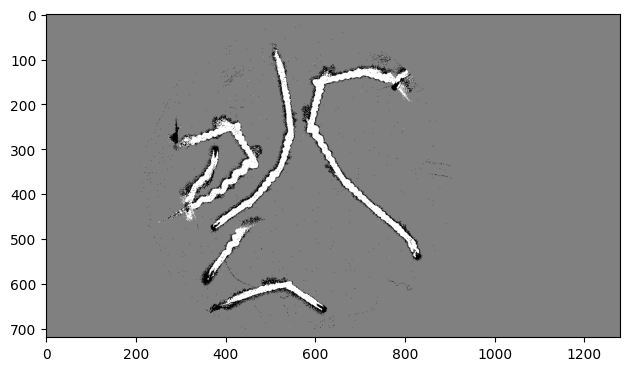

In [66]:
height, width = record_raw.get_size()

# load the next 50 ms worth of events
# events = record_raw.load_delta_t(50000)
im = viz_events(inside_events, height, width)

plt.imshow(im)
plt.tight_layout()

In [38]:
def viz_events(events, height, width):
    img = np.full((height, width, 3), 128, dtype=np.uint8)
    img[events['y'], events['x']] = 255 * events['p'][:, None]
    return img

In [13]:
bins = calculate_bin_number(events, dt=1000)

In [14]:
bins

15182

In [15]:
len(events)

236083

In [72]:
events[0:3]

array([(834, 596, 1, 8214), (925,   4, 0, 9194), (767, 127, 0, 9410)],
      dtype={'names': ['x', 'y', 'p', 't'], 'formats': ['<u2', '<u2', '<i2', '<i8'], 'offsets': [0, 2, 4, 8], 'itemsize': 16})

In [16]:
def viz_events(events, height, width):
    img = np.full((height, width, 3), 128, dtype=np.uint8)
    img[events['y'], events['x']] = 255 * events['p'][:, None]
    return img

In [79]:
on_hist, on_edges = np.histogram(on_events['t'], density=False, bins=bins)
off_hist, off_edges = np.histogram(off_events['t'], density=False, bins=bins)

In [77]:
len(off_edges)

15183

In [110]:
on_hist[8170]

144

In [111]:
off_hist[8170]

162

In [112]:
source = ColumnDataSource(data=dict(edges=on_edges[:-1], on_hist=on_hist, off_hist=off_hist))

p = figure(height=400, width=950, tools="xpan", toolbar_location=None,
           x_axis_location="below", background_fill_color="#efefef",x_range=(edges[8150], edges[8350]))

p.quad(top=off_hist, bottom=0, left=on_edges[:-1], right=on_edges[1:],
         fill_color="darkred", line_width=0)
p.quad(top=on_hist+off_hist, bottom=off_hist, left=on_edges[:-1], right=on_edges[1:],
         fill_color="royalblue", line_width=0)
p.y_range.start = 0
p.xaxis.axis_label = "t (us)"
p.yaxis.axis_label = "Events"

select = figure(title="Event Selection",
                height=230, width=950, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('edges', 'on_hist', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)

show(column(p, select))

In [103]:
source = ColumnDataSource(data=dict(edges=on_edges[:-1], on_hist=on_hist, off_hist=off_hist))

p = figure(height=300, width=950, tools="xpan", toolbar_location=None,
           x_axis_location="below", background_fill_color="#efefef",x_range=(edges[8150], edges[8350]))

p.quad(top=off_hist, bottom=0, left=on_edges[:-1], right=on_edges[1:],
         fill_color="darkred", line_width=0)
p.y_range.start = 0
p.yaxis.axis_label = "Off Events"

q = figure(height=300, width=950, tools="xpan", toolbar_location=None,
           x_axis_location="below", background_fill_color="#efefef",x_range=(edges[8150], edges[8350]))
q.quad(top=on_hist, bottom=0, left=on_edges[:-1], right=on_edges[1:],
         fill_color="royalblue", line_width=0)
q.xaxis.axis_label = "t (us)"
q.yaxis.axis_label = "On Events"

select = figure(title="Event Selection",
                height=230, width=950, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('edges', 'on_hist', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)

show(column(q, p, select))

In [105]:
source = ColumnDataSource(data=dict(edges=on_edges[:-1], on_hist=on_hist, off_hist=off_hist))

p = figure(height=300, width=950, tools="xpan", toolbar_location=None,
           x_axis_location="below", background_fill_color="#efefef",x_range=(edges[8150], edges[8200]))

p.quad(top=off_hist, bottom=0, left=on_edges[:-1], right=on_edges[1:],
         fill_color="darkred", line_width=0)
p.y_range.start = 0
p.yaxis.axis_label = "Off Events"

q = figure(height=300, width=950, tools="xpan", toolbar_location=None,
           x_axis_location="below", background_fill_color="#efefef",x_range=(edges[8150], edges[8200]))
q.quad(top=on_hist, bottom=0, left=on_edges[:-1], right=on_edges[1:],
         fill_color="royalblue", line_width=0)
q.xaxis.axis_label = "t (us)"
q.yaxis.axis_label = "On Events"

select = figure(title="Event Selection",
                height=230, width=950, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('edges', 'on_hist', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)

show(column(q, p, select))

In [66]:
p.x_range

Range1d(id='p1924', ...)

In [8]:
rng = np.random.default_rng()
x = rng.normal(loc=0, scale=1, size=10000)

p = figure(width=670, height=400, toolbar_location=None,
           title="Normal (Gaussian) Distribution")

# Histogram
bins = np.linspace(-3, 3, 40)
hist, edges = np.histogram(x, density=True, bins=bins)
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color="skyblue", line_color="white",
         legend_label="1000 random samples")

# Probability density function
# x = np.linspace(-3.0, 3.0, 100)
# pdf = np.exp(-0.5*x**2) / np.sqrt(2.0*np.pi)
#p.line(x, pdf, line_width=2, line_color="navy",
#       legend_label="Probability Density Function")

p.y_range.start = 0
p.xaxis.axis_label = "x"
p.yaxis.axis_label = "PDF(x)"

show(p)

In [ ]:
events['p']

In [ ]:
len(events['t'])

In [ ]:
type(events[4])

In [ ]:
events2 = np.array([[events['t'], events['x'], events['y'], events['p']]])
events2 = np.array([[events['t'], events['x'], events['y']]])

In [ ]:
events[3][1]

In [ ]:
print(events[2])
print(np.roll(events[2],2))

In [ ]:
type(events2)

In [ ]:
events2.shape

In [ ]:
events2

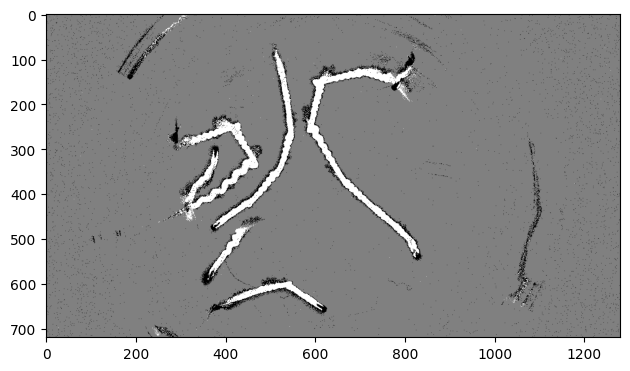

In [40]:
height, width = record_raw.get_size()

# load the next 50 ms worth of events
# events = record_raw.load_delta_t(50000)
im = viz_events(events, height, width)

plt.imshow(im)
plt.tight_layout()

In [ ]:
plt.hist(events['t'], bins=1000)

In [ ]:
intereventintervals = np.diff(events['t'])

In [ ]:
plt.hist(intereventintervals, bins=50, range=(0,50))

### Numpy arrays have names for columns!

In [ ]:
events.dtype.names

### Napari plot

In [ ]:
from skimage import data

In [ ]:
viewer = napari.Viewer()

In [ ]:
points = np.array([[1, 100, 100, 2], [2, 200, 200, 4], [3, 300, 100, 4]])

In [ ]:
points_layer = viewer.add_points(events[:10000], size=2)

In [ ]:
record_raw.get_size()